
# Image Compression using Dual PCA  
# Multiple Images Compressed Simultaneously
### Students: Goldie Srulovich, Aaron Herbert

In [1]:
import os
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
from numpy.linalg import eig
import random
import zipfile
from sklearn.preprocessing import StandardScaler

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
with zipfile.ZipFile(".\\Random_Images_PCA.zip","r") as zip_ref:
    zip_ref.extractall("Random_Images_PCA")

In [4]:
DATASET_DIR = ".\\Random_Images_PCA\\Random_Images_PCA"
DIR = os.listdir(DATASET_DIR)
IMG_WIDTH = 200
D = IMG_WIDTH * IMG_WIDTH # higher dimension value = # total pixels = IMG_WIDTH x IMG_WIDTH
d = None # lower dimension value value assigned in test_img_compression func below

In [5]:
def get_eigendecomp(X):
    #covX = np.cov(mX)
    eigenvalues, U = eig(X)
    λ = np.sort(eigenvalues)[::-1]
    # Sort U in descending order
    U_descending = U[:, np.argsort(λ)[::-1]]

    return λ, U_descending

In [6]:
#convert 3 channel image representation into 1 channel image representation
def rgb_to_1channel(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    
    return gray

In [7]:
#Read all images inside DIR
def read_all_images():

    all_images = []
    
    for i, file in enumerate(DIR):
        fullpath = DATASET_DIR + "\\" + file
        try:
            img = cv2.imread(fullpath)
            #convert the image representation from 3 rgb channels to 1 channel
            img = rgb_to_1channel(img)
            #Resize all images to be same size, i.e. (IMG_WIDTH,IMG_WIDTH) 
            res = cv2.resize(img, dsize=(IMG_WIDTH,IMG_WIDTH), interpolation=cv2.INTER_AREA)
            img = res.flatten()
            all_images.append(img)
            #plt.imshow(res)
            #plt.show()
        except:
            continue
        
    return all_images


In [8]:
#Returns X (matrix containing pixels of all images), mean of X and XTX=X transpose X
def get_X_Xmean_XTX(all_images):
    imgs = all_images.copy()
    X = np.zeros((IMG_WIDTH*IMG_WIDTH,len(imgs)))

    for i in range(len(imgs)):
        X[:,i] = imgs[i]

    X_mean = np.mean(X, axis=1)
    #subtract the mean from data (before applying dual PCA)
    X = X - X_mean[:, np.newaxis]

    XTX = X.T @ X
    return X, X_mean, XTX

In [9]:
#Implementation of dual PCA algorithm, project D into lower dimension, d
def dual_PCA(all_images, d):
    
    X, X_mean, XTX = get_X_Xmean_XTX(all_images)
    
    lamb, V = get_eigendecomp(XTX) #decompose XTX
    
    lamb = lamb ** 0.5 #Compute singular values from eigenvalues
    lamb_d = lamb[:d]
    
    lamb = np.diag(lamb)
    lamb_d = np.diag(lamb_d)
    
    lamb_inv = np.linalg.inv(lamb)
    lamb_inv_d = np.linalg.inv(lamb_d)

    V_d = V[:, :d]

    U_d = X @ V_d @ lamb_inv_d #compute U_d
    Z = lamb_d @ V_d.T #compute latent space representation
    
    X_hat = (U_d @ Z) + X_mean[:, np.newaxis] #reconstruct the lower dimensional data into original dimensional space

    return X_hat

In [10]:
#Here we test the dual PCA image compression algorithm 
#we test incremental lower-dimensional projections, d, from 1 until the number of samples/images 
#since the rank of the matrix is at most its lower dimension
def test_img_compression():
    original_images = read_all_images()
    all_images = original_images.copy()
    
    all_d_tests = [i for i in range(1, len(all_images))]
    print('d = ',all_d_tests)
    
    for d in all_d_tests:
        
        compressed_images = dual_PCA(original_images, d) #compress the original images matrix into lower dimension d
        X_hat = compressed_images.copy()
        
        all_compressed = []
        all_original = []
        rand_image_indxs = []
    
        for i in range(3):
            #Choose a random image:
            while(True):
                rand_image_indx = random.randint(0, len(all_images) -1) 
                if rand_image_indx not in rand_image_indxs:
                    break
            rand_image_indxs.append(rand_image_indx)
            img = X_hat[:,rand_image_indx] #index the random image from reconstructed data
            
            #reshape flattened pixels into (IMG_WIDTH,IMG_WIDTH):
            img_compressed = img.reshape((int(np.sqrt(img.shape[0])),int(np.sqrt(img.shape[0]))))  
            img_original = all_images[rand_image_indx].reshape((int(np.sqrt(img.shape[0])),int(np.sqrt(img.shape[0]))))
            
            all_compressed.append(img_compressed)
            all_original.append(img_original)
        
        fig, axs = plt.subplots(3, 2)
        fig.set_figheight(15)
        fig.set_figwidth(15)
        
        fig.suptitle('d = ' + str(d), fontsize=25)
        
        #Plot all images belonging to this specific low dimension d
        for i in range(len(all_compressed)):
        
            axs[i, 0].set_title('Original img #' + str(rand_image_indxs[i]))
            axs[i, 0].imshow(all_original[i])
            axs[i, 1].set_title('Compressed img #' + str(rand_image_indxs[i]))
            axs[i, 1].imshow(all_compressed[i])
        
        plt.show()

d =  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


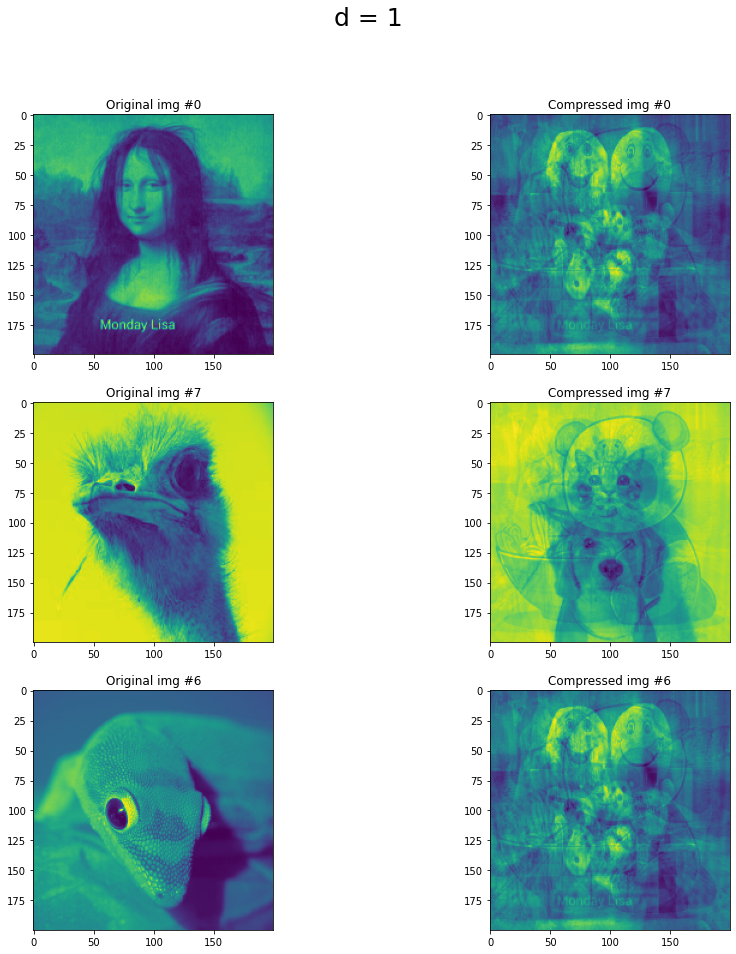

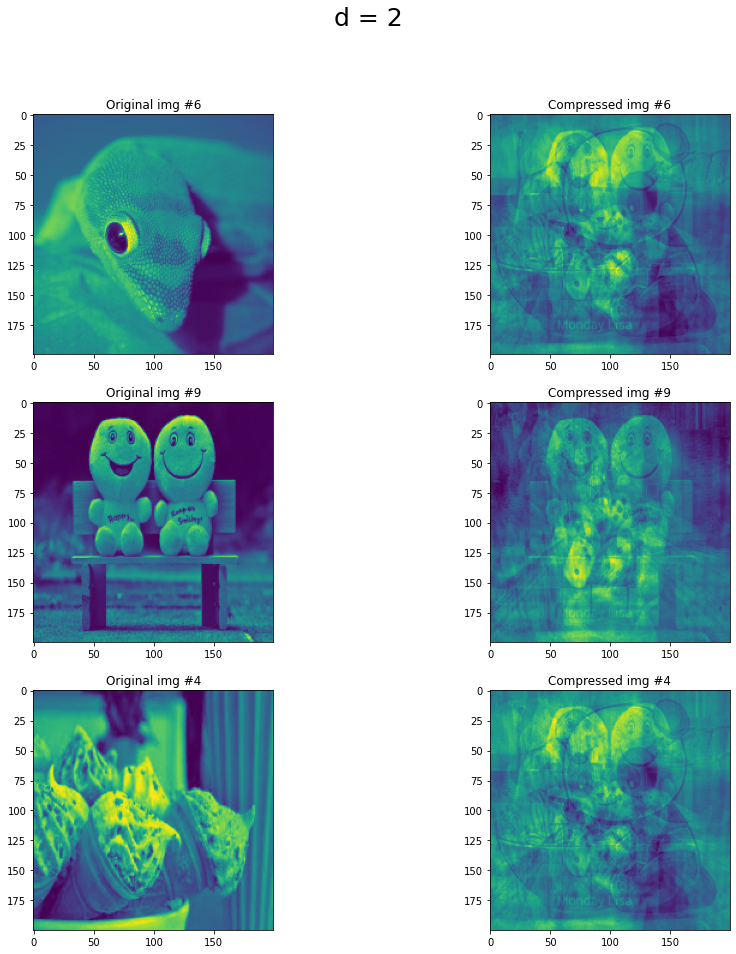

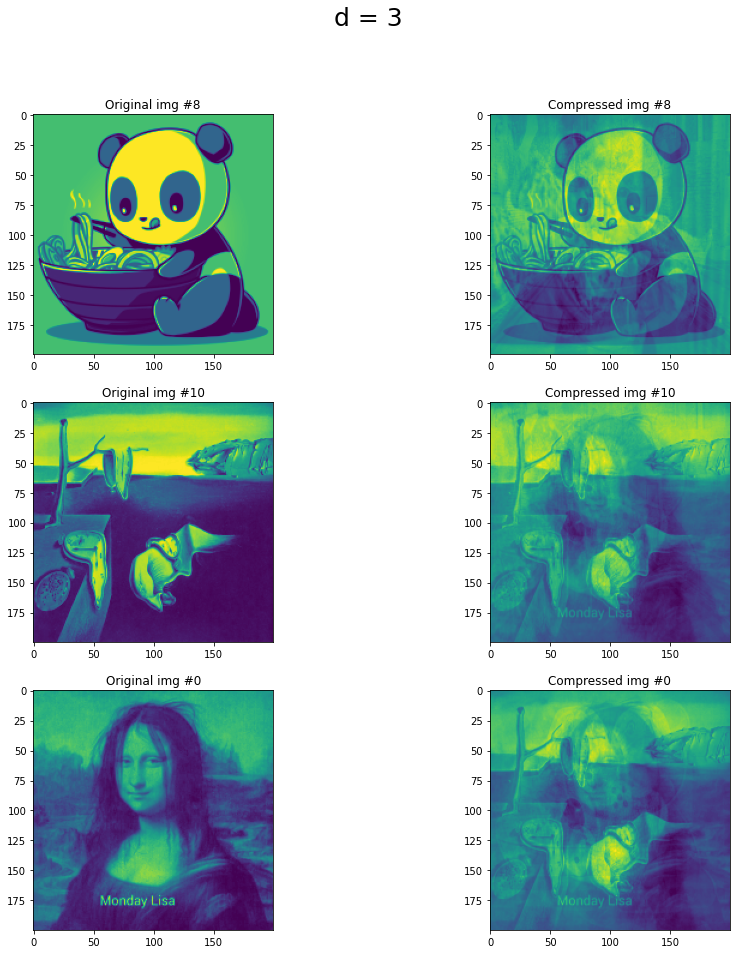

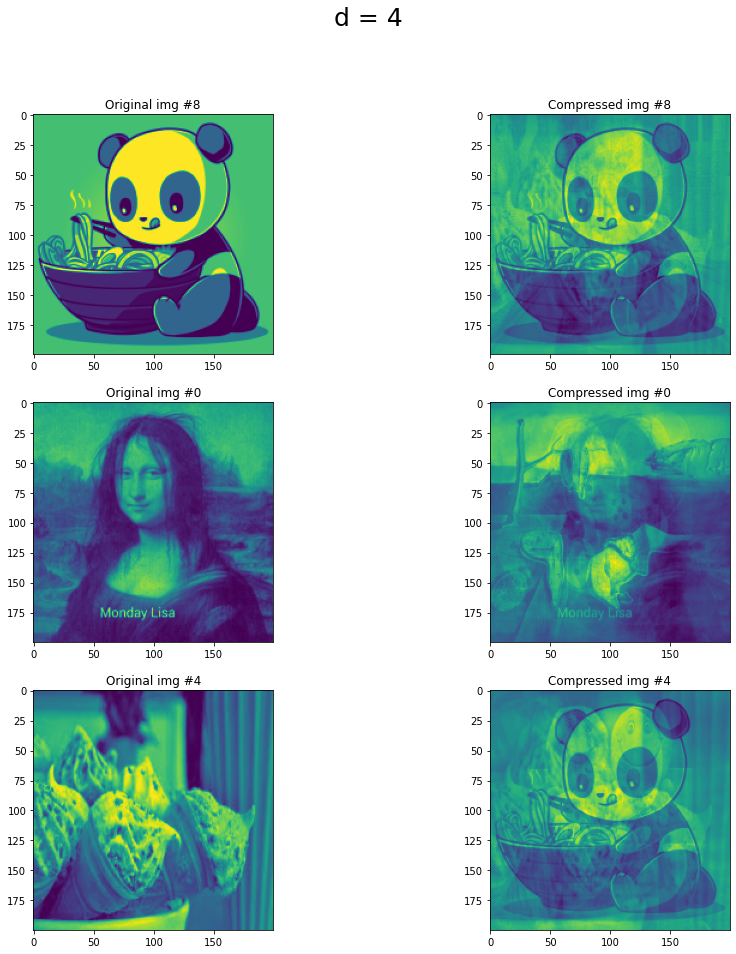

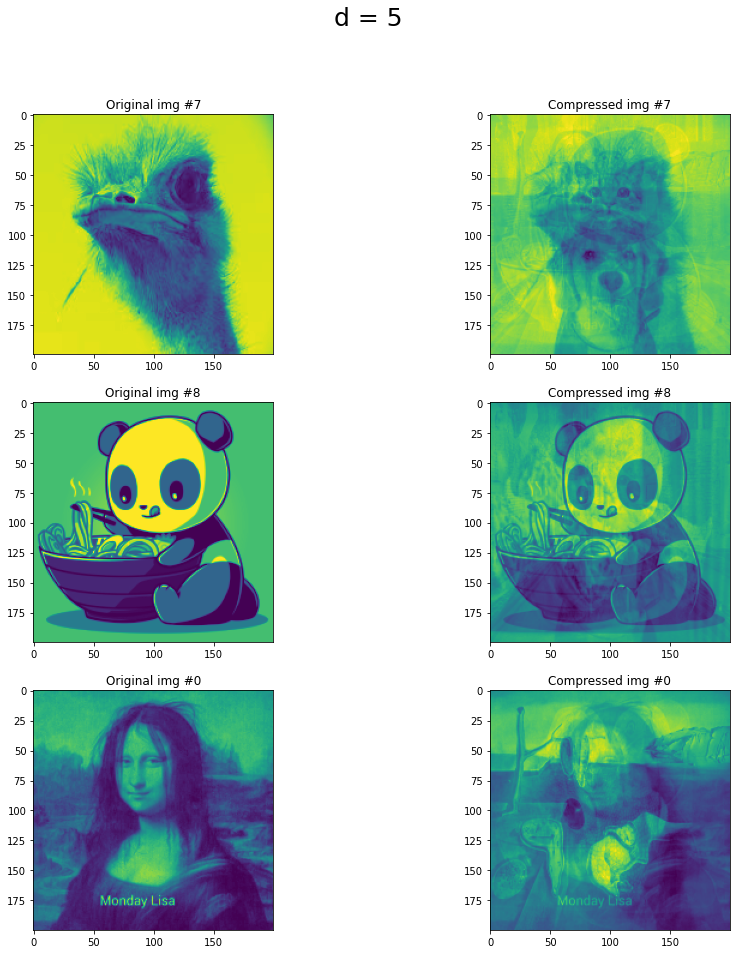

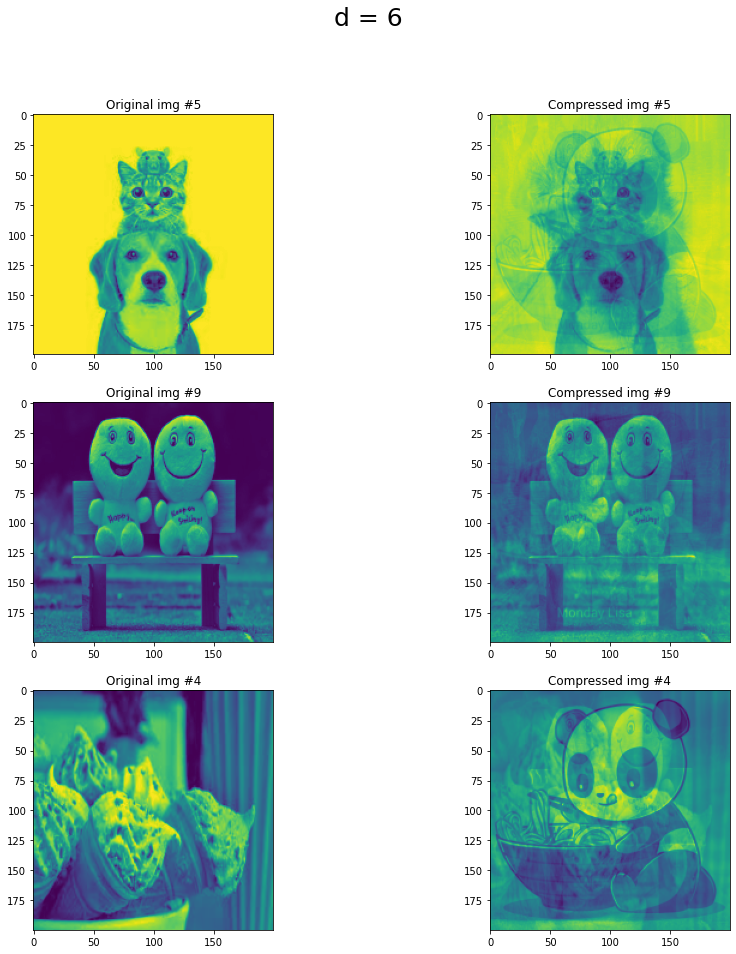

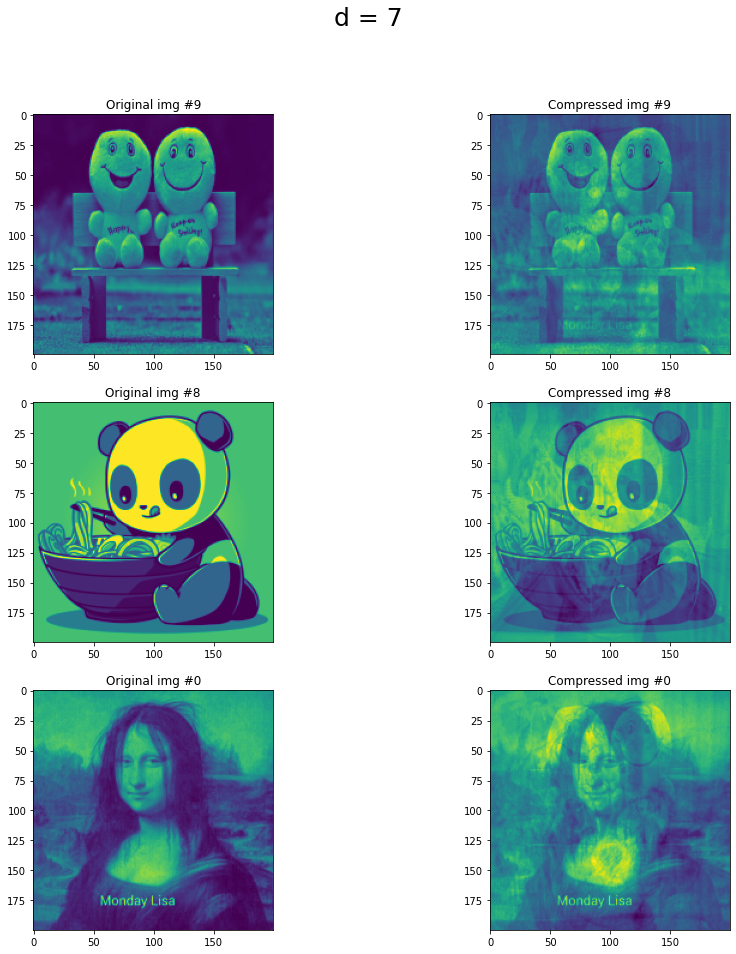

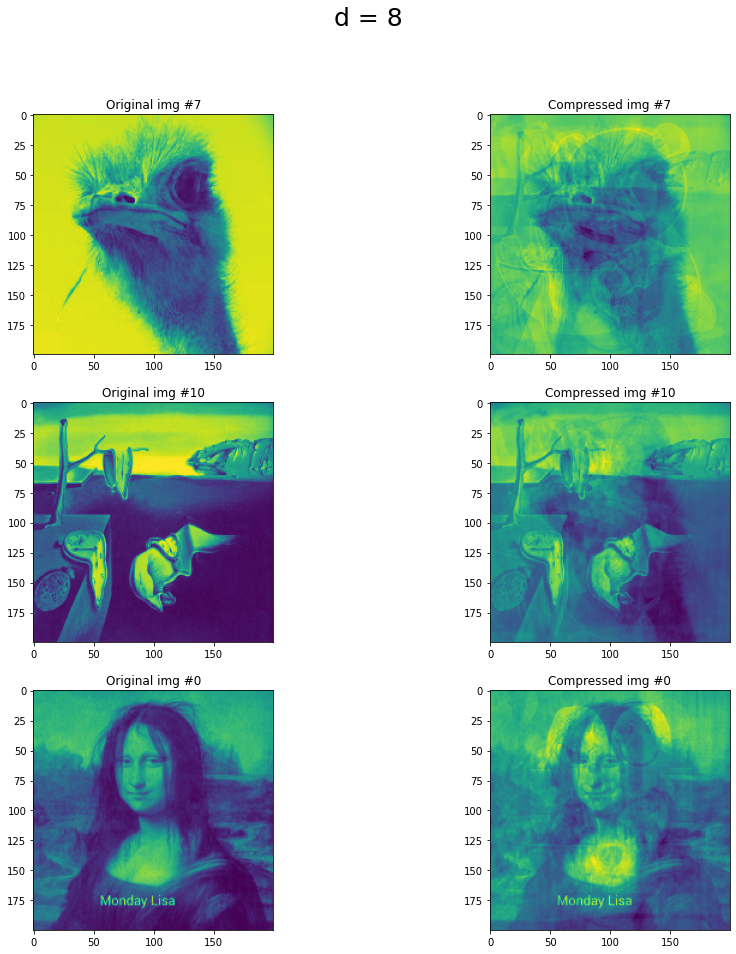

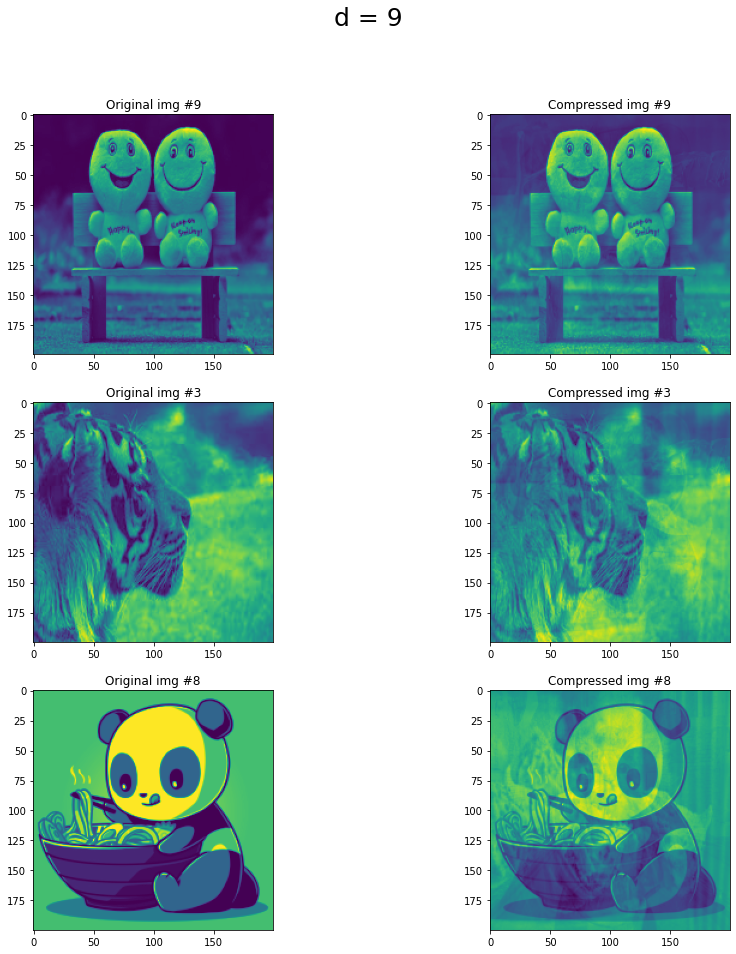

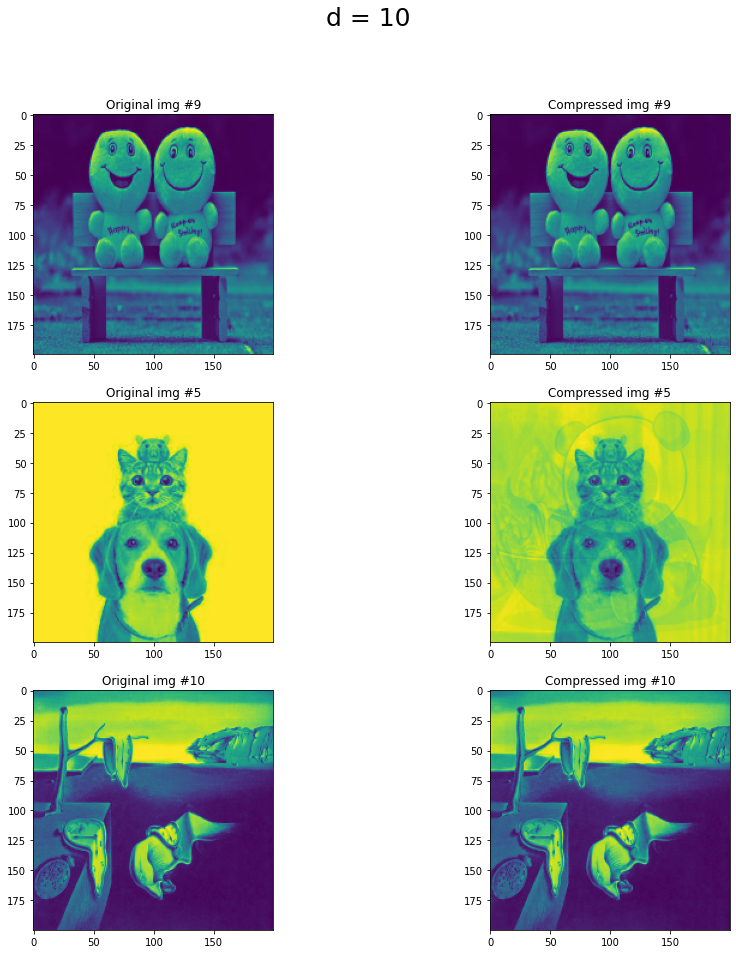

In [11]:
#Run the tests
test_img_compression()

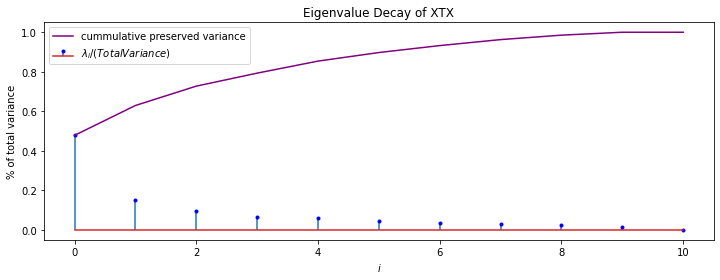

In [12]:
#Here we plot the eigenvalue decay of XTX 
#since eignevalues are sorted it displays the percent of total variance of the matrix captured by eignevalue at position i
all_images = read_all_images()
_,_,mX = get_X_Xmean_XTX(all_images)
vλ,_ = get_eigendecomp(mX)
sum_vλ = np.sum(vλ)
plt.figure(figsize=(12, 4))
plt.stem(vλ / sum_vλ, markerfmt="b.", label="$\\lambda_i / (Total Variance)$")
plt.plot((vλ / sum_vλ).cumsum(), color='purple', label="cummulative preserved variance")
plt.title("Eigenvalue Decay of XTX")
plt.xlabel("$i$")
plt.ylabel("% of total variance")
plt.legend()
plt.show()